Equivalence MAE at clone time: 1.53730308483091e-08


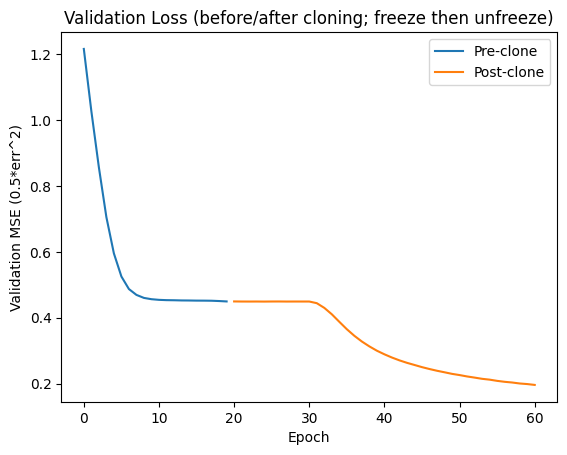

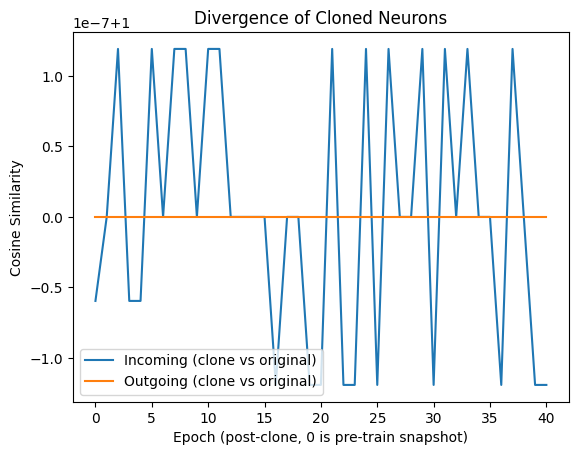

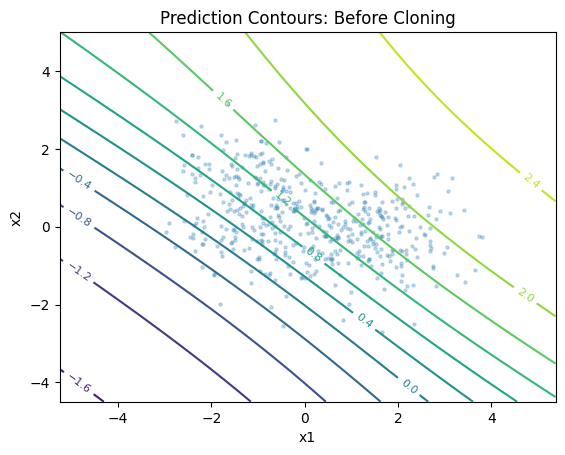

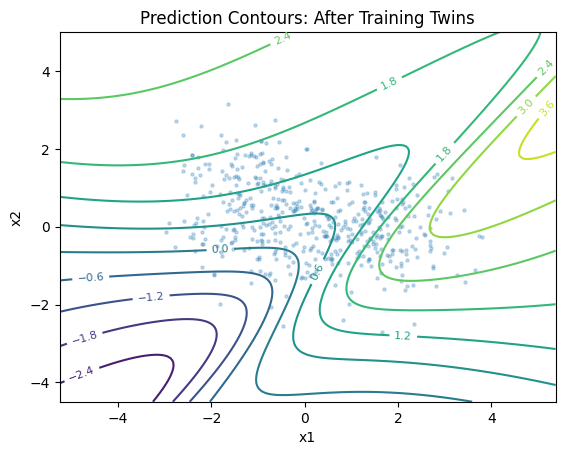

In [2]:
# tf_twin_divergence_refactored.py
# One-hidden-layer regression demo: train → clone a neuron → split outgoing weights (function invariant)
# → freeze twins only → unfreeze all → plot validation loss, twin divergence, and contours.
# Refactored to (1) keep eager mode in train_step and (2) use a fresh optimizer for the widened model.

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(1234)
tf.random.set_seed(1234)

# -----------------------------------------------------------------------------
# Data: regression with two regimes (creates competing directions)
# -----------------------------------------------------------------------------

def make_data(n_per=1500, noise=0.1):
    xa = np.random.randn(n_per, 2) * np.array([1.0, 0.7]) + np.array([1.2, -0.2])
    ya = 0.9*xa[:,0] - 0.6*xa[:,1] + 0.3
    xb = np.random.randn(n_per, 2) * np.array([0.8, 1.0]) + np.array([-1.0, 0.6])
    yb = -0.5*xb[:,0] + 0.9*xb[:,1] - 0.2

    X = np.vstack([xa, xb]).astype(np.float32)
    y = np.concatenate([ya, yb]).astype(np.float32)
    y += noise*np.random.randn(*y.shape)

    idx = np.random.permutation(len(y))
    X, y = X[idx], y[idx]
    ntr = int(0.8*len(y))
    return X[:ntr], y[:ntr], X[ntr:], y[ntr:]

Xtr, ytr, Xte, yte = make_data()

# -----------------------------------------------------------------------------
# Model builder
# -----------------------------------------------------------------------------

def build_model(hidden_units: int) -> tf.keras.Model:
    inp = tf.keras.Input((2,))
    h = tf.keras.layers.Dense(hidden_units, activation='tanh', name='hidden')(inp)
    out = tf.keras.layers.Dense(1, activation=None, name='out')(h)
    return tf.keras.Model(inp, out)

# -----------------------------------------------------------------------------
# Training utilities (eager train_step to avoid NotImplementedError in graph)
# -----------------------------------------------------------------------------

def train_step(model: tf.keras.Model,
               x: np.ndarray,
               t: np.ndarray,
               optimizer: tf.keras.optimizers.Optimizer,
               mask=None,
               weight_decay: float = 1e-4) -> float:
    """Single SGD/Adam step with optional gradient mask for freezing.

    mask is a list aligned with model.trainable_variables; each entry is a tensor
    of 0/1 (or broadcastable) to zero-out gradients for frozen variables.
    """
    with tf.GradientTape() as tape:
        yhat = model(x, training=True)
        loss = 0.5*tf.reduce_mean(tf.square(yhat - tf.reshape(t, (-1,1))))
        for v in model.trainable_variables:
            if 'kernel' in v.name:
                loss += 0.5*weight_decay*tf.reduce_sum(tf.square(v))
    grads = tape.gradient(loss, model.trainable_variables)
    if mask is not None:
        grads = [None if g is None else g * m for g, m in zip(grads, mask)]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return float(loss.numpy())


def evaluate(model: tf.keras.Model, x: np.ndarray, t: np.ndarray) -> float:
    yhat = model(x, training=False).numpy().reshape(-1)
    return float(0.5*np.mean((yhat - t)**2))


def minibatches(X, y, bs):
    n = X.shape[0]
    order = np.random.permutation(n)
    for i in range(0, n, bs):
        idx = order[i:i+bs]
        yield X[idx], y[idx]


def cosine(u, v, eps=1e-12):
    u = u.reshape(-1); v = v.reshape(-1)
    return float(np.dot(u, v)/(np.linalg.norm(u)*np.linalg.norm(v)+eps))

# -----------------------------------------------------------------------------
# Phase 1: train small underfit model
# -----------------------------------------------------------------------------

hidden = 3
model = build_model(hidden)
opt1 = tf.keras.optimizers.Adam(3e-3)

val_loss_hist = []
for ep in range(20):
    for xb, yb in minibatches(Xtr, ytr, 128):
        train_step(model, xb, yb, opt1)
    val_loss_hist.append(evaluate(model, Xte, yte))

# -----------------------------------------------------------------------------
# Clone one hidden neuron: copy incoming, split outgoing 50/50 (function invariant)
# -----------------------------------------------------------------------------

W1, b1 = model.get_layer('hidden').get_weights()   # (2, H), (H,)
W2, b2 = model.get_layer('out').get_weights()      # (H, 1), (1,)
# Most influential neuron by outgoing weight norm
j = int(np.argmax(np.linalg.norm(W2, axis=1)))

model2 = build_model(hidden + 1)
W1_new = np.zeros((2, hidden+1), np.float32); W1_new[:, :hidden] = W1; W1_new[:, hidden] = W1[:, j]
b1_new = np.zeros((hidden+1,), np.float32); b1_new[:hidden] = b1; b1_new[hidden] = b1[j]
W2_new = np.zeros((hidden+1, 1), np.float32); W2_new[:hidden, :] = W2
W2_new[j, :] = 0.5*W2[j, :]; W2_new[hidden, :] = 0.5*W2[j, :]
b2_new = b2.copy()

model2.get_layer('hidden').set_weights([W1_new, b1_new])
model2.get_layer('out').set_weights([W2_new, b2_new])

# Function invariance check
p_old = model(Xte, training=False).numpy()
p_new = model2(Xte, training=False).numpy()
print("Equivalence MAE at clone time:", float(np.mean(np.abs(p_old - p_new))))

# -----------------------------------------------------------------------------
# Phase 2: freeze twins only → then unfreeze all
# -----------------------------------------------------------------------------

opt2 = tf.keras.optimizers.Adam(3e-3)
_ = [v for v in model2.trainable_variables]  # ensure variables are created
opt2.build(model2.trainable_variables)

H = hidden
clone_idx = hidden

# Build gradient masks for freezing: allow updates only on twins (incoming/outgoing) and output bias
# trainable_variables order: [hidden/kernel, hidden/bias, out/kernel, out/bias]
tv = model2.trainable_variables
mask_W1 = np.zeros_like(tv[0].numpy())    # (2, H+1)
mask_b1 = np.zeros_like(tv[1].numpy())    # (H+1,)
mask_W2 = np.zeros_like(tv[2].numpy())    # (H+1, 1)
mask_b2 = np.ones_like(tv[3].numpy())     # keep output bias trainable
mask_W1[:, j] = 1.0; mask_W1[:, clone_idx] = 1.0
mask_b1[j] = 1.0; mask_b1[clone_idx] = 1.0
mask_W2[j, :] = 1.0; mask_W2[clone_idx, :] = 1.0
freeze_mask = [tf.constant(mask_W1), tf.constant(mask_b1), tf.constant(mask_W2), tf.constant(mask_b2)]
full_mask = [tf.ones_like(tv[0]), tf.ones_like(tv[1]), tf.ones_like(tv[2]), tf.ones_like(tv[3])]

# Logs
val_loss_hist2 = [val_loss_hist[-1]]
cos_in_hist, cos_out_hist = [], []

# initial cosine (right after cloning)
W1c, b1c = model2.get_layer('hidden').get_weights()
W2c, b2c = model2.get_layer('out').get_weights()
cos_in_hist.append(cosine(W1c[:, j], W1c[:, clone_idx]))
cos_out_hist.append(cosine(W2c[j, :], W2c[clone_idx, :]))

# Freeze phase
for ep in range(10):
    for xb, yb in minibatches(Xtr, ytr, 128):
        train_step(model2, xb, yb, opt2, mask=freeze_mask)
    val_loss_hist2.append(evaluate(model2, Xte, yte))
    W1c, b1c = model2.get_layer('hidden').get_weights()
    W2c, b2c = model2.get_layer('out').get_weights()
    cos_in_hist.append(cosine(W1c[:, j], W1c[:, clone_idx]))
    cos_out_hist.append(cosine(W2c[j, :], W2c[clone_idx, :]))

# Unfreeze phase
for ep in range(30):
    for xb, yb in minibatches(Xtr, ytr, 128):
        train_step(model2, xb, yb, opt2, mask=full_mask)
    val_loss_hist2.append(evaluate(model2, Xte, yte))
    W1c, b1c = model2.get_layer('hidden').get_weights()
    W2c, b2c = model2.get_layer('out').get_weights()
    cos_in_hist.append(cosine(W1c[:, j], W1c[:, clone_idx]))
    cos_out_hist.append(cosine(W2c[j, :], W2c[clone_idx, :]))

# -----------------------------------------------------------------------------
# Plots
# -----------------------------------------------------------------------------

plt.figure()
plt.plot(range(len(val_loss_hist)), val_loss_hist, label='Pre-clone')
plt.plot(range(len(val_loss_hist), len(val_loss_hist)+len(val_loss_hist2)), val_loss_hist2, label='Post-clone')
plt.xlabel('Epoch')
plt.ylabel('Validation MSE (0.5*err^2)')
plt.title('Validation Loss (before/after cloning; freeze then unfreeze)')
plt.legend(); plt.show()

plt.figure()
plt.plot(range(len(cos_in_hist)), cos_in_hist, label='Incoming (clone vs original)')
plt.plot(range(len(cos_out_hist)), cos_out_hist, label='Outgoing (clone vs original)')
plt.xlabel('Epoch (post-clone, 0 is pre-train snapshot)')
plt.ylabel('Cosine Similarity')
plt.title('Divergence of Cloned Neurons')
plt.legend(); plt.show()

# Contour plots (before vs after)

def predict(m, X):
    return m(X, training=False).numpy().reshape(-1)

allX = np.vstack([Xtr, Xte])
gx = np.linspace(allX[:,0].min()-1.5, allX[:,0].max()+1.5, 180)
gy = np.linspace(allX[:,1].min()-1.5, allX[:,1].max()+1.5, 180)
GX, GY = np.meshgrid(gx, gy)
G = np.stack([GX.ravel(), GY.ravel()], axis=1).astype(np.float32)

Y_pre = predict(model, G).reshape(GX.shape)
Y_post = predict(model2, G).reshape(GX.shape)

plt.figure(); cs=plt.contour(GX, GY, Y_pre, levels=12); plt.clabel(cs, inline=True, fontsize=8)
plt.scatter(Xte[:500,0], Xte[:500,1], s=5, alpha=0.25)
plt.xlabel('x1'); plt.ylabel('x2'); plt.title('Prediction Contours: Before Cloning'); plt.show()

plt.figure(); cs=plt.contour(GX, GY, Y_post, levels=12); plt.clabel(cs, inline=True, fontsize=8)
plt.scatter(Xte[:500,0], Xte[:500,1], s=5, alpha=0.25)
plt.xlabel('x1'); plt.ylabel('x2'); plt.title('Prediction Contours: After Training Twins'); plt.show()

# -----------------------------------------------------------------------------
# Optional: enable gradient-separation probe (two-means score) if desired
# -----------------------------------------------------------------------------
# You can add a hook to collect per-batch pre-activation gradients for neuron j & clone,
# run spherical 2-means on their normalized directions, and log separation vs. time.
# Keeping it off by default for clarity.
